-----------------------------------------------
__NAME: *Karan Rathour*__   
__ANDREW ID: *krathour*__    
__SUBJECT: *DSPM 95851*__    
__ASSIGNMENT: *HW 3*__

-----------------------------------------------

### 1. Reading the file 
- Read the csv file using pandas
- Check the info of the loaded data frame
- Remove the rows where consumer complaint narrative is blank

In [17]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

In [18]:
# Reading the complaint files
%time
complaints = pd.read_csv("Consumer_Complaints.csv")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.25 µs


/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (4,5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
complaints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1219000 entries, 0 to 1218999
Data columns (total 18 columns):
Date received                   1219000 non-null object
Product                         1219000 non-null object
Sub-product                     983834 non-null object
Issue                           1219000 non-null object
Sub-issue                       695948 non-null object
Consumer complaint narrative    367168 non-null object
Company public response         417200 non-null object
Company                         1219000 non-null object
State                           1201633 non-null object
ZIP code                        1112890 non-null object
Tags                            166425 non-null object
Consumer consent provided?      651861 non-null object
Submitted via                   1219000 non-null object
Date sent to company            1219000 non-null object
Company response to consumer    1218994 non-null object
Timely response?                1219000 non-null obje

In [20]:
complaints = complaints[pd.notna(complaints.iloc[:, 5])]
print("The number of rows in the dataframe now are {}".format(len(complaints)))

The number of rows in the dataframe now are 367168


In [21]:
complaints.head(3)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
371,02/10/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,All accounts have been paid in full and are no...,Company has responded to the consumer and the ...,"Convergent Resources, Inc.",TN,371XX,NaN,Consent provided,Web,02/10/2019,Closed with explanation,Yes,NaN,3148129
418,02/09/2019,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,A message from Harris Debt collection at phone...,Company believes it acted appropriately as aut...,"Harris & Harris, Ltd.",IA,NaN,NaN,Consent provided,Web,02/09/2019,Closed with explanation,Yes,NaN,3147588
623,02/08/2019,Debt collection,Medical debt,Written notification about debt,Didn't receive enough information to verify debt,I checked my credit report this year to see th...,Company believes it acted appropriately as aut...,Millco Management,MD,212XX,NaN,Consent provided,Web,02/08/2019,Closed with explanation,Yes,NaN,3146689


----
### 2. Histogram of number of complaints by company name.

In [22]:
complaints_hist = complaints.groupby("Company")
complaints_hist = complaints_hist.aggregate("count")["Consumer complaint narrative"]
complaints_hist = complaints_hist.reset_index()
complaints_hist.sort_values(by = "Consumer complaint narrative", ascending = False, inplace = True)

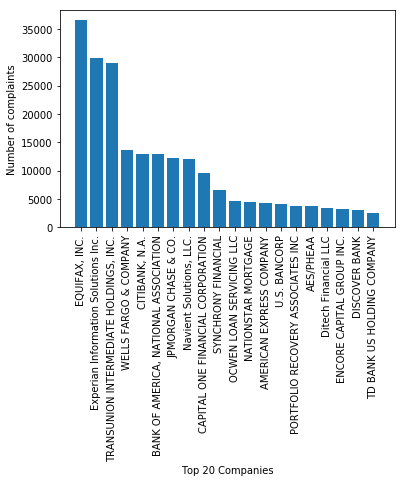

In [23]:
x = complaints_hist.iloc[:20, 0].values
h = complaints_hist.iloc[:20, 1].values
plt.bar(x , h)
plt.xticks(rotation = 90)
plt.xlabel("Top 20 Companies")
plt.ylabel("Number of complaints")
plt.show()

**Thus we see that the top 2 companies with the majority share of complaints are credit rating agencies. These are folowed by financial organizations.**

### 3. Feature building

Process followed:
1. Dataset preparation
    - Creating a two column dataset with the level and the comments for each classifcation level - products, subproducts, issues and sub issues
-  Tokenize all the complaints in the various documents: CountVectorizer is used with tokenization engine as Spacy.This lemmatized and vectorizes the lemmasremoving terms that occur too frequently, not frequently enough, or that are stop words
- Once the lemmatization is complete we, then use the Tfid vectoriztion to create the feature matrix. The feature matrix here are the top 5000 lemmas in the tonkenized bversion. the values are balanced to include weights given on their presence in each document vs that document 
- Once that is done we can run LDA for dimensionality reduction. In this case we wont, as the computation time would increase by a huge extent. 
- Check to see what are the distribution of different words in teach topic 
- Once that is done, we can go on to the next part of the problem i.e model building. 

In [24]:
model_df = complaints.loc[:, ["Product" ,"Sub-product","Issue","Sub-issue", "Consumer complaint narrative"]]
# model_df.columns = ["labels", "texts" ]
for label in ["Product" ,"Sub-product","Issue","Sub-issue"]:
    print("The dataset has {} unique {}s and total of {} data points(rows).".format(len(model_df[label].unique()) , label, len(model_df)))

The dataset has 18 unique Products and total of 367168 data points(rows).
The dataset has 76 unique Sub-products and total of 367168 data points(rows).
The dataset has 161 unique Issues and total of 367168 data points(rows).
The dataset has 216 unique Sub-issues and total of 367168 data points(rows).


In [25]:
# Pre processing the data to remove special characters and spaces from the labels
for label in ["Product" ,"Sub-product","Issue","Sub-issue"]:
    model_df[label] =  model_df[label].str.replace('[^A-Za-z0-9]+', '')

In [91]:
# Splitting the dataset into test and train set
from sklearn.model_selection import train_test_split
train_x, valid_x, train_y_p, valid_y_p , train_y_sp, valid_y_sp , train_y_issue, valid_y_issue , train_y_sub_issue, valid_y_sub_issue ,  = train_test_split(model_df['Consumer complaint narrative'], model_df['Product'] , model_df['Sub-product'], model_df['Issue'], model_df['Sub-issue'] ,test_size = 0.3, random_state = 8)

In [27]:
# Encode the label of the target variable 
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
train_y_p = encoder.fit_transform(train_y_p)
valid_y_p = encoder.fit_transform(valid_y_p)

In [28]:
# Starting feature engineering process 
vocab_size = 5000
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tf_vectorizer = CountVectorizer(max_df=0.95,
                                min_df=2,
                                max_features=vocab_size,
                                stop_words='english')

In [29]:
import spacy
spacy.prefer_gpu()

nlp = spacy.load('en', disable=['ner', 'parser', 'tagger'])
nlp.max_length = 6000000

# tokenize the doc and lemmatize its tokens
def my_tokenizer(doc):
    tokens = nlp(doc)
    return([token.lemma_ for token in tokens])

custom_vec = TfidfVectorizer(tokenizer=my_tokenizer, max_df=0.95,
                                min_df=2,
                                max_features=vocab_size,
                                stop_words='english')



In [30]:
# REMOVE THIS CODE TO RUN ON FULL DATA
# train_x = train_x[:1000]
# valid_x = valid_x[:1000]

In [31]:
%%time
# word level tf-idf
custom_vec.fit(train_x)
xtrain_tfidf =  custom_vec.transform(train_x)
xvalid_tfidf =  custom_vec.transform(valid_x)

CPU times: user 25min 26s, sys: 504 ms, total: 25min 27s
Wall time: 25min 27s


In [34]:
# # RUN THIS FOR NGRAM LEVEL TF_IDF - NOT RUNNING IT THIS TIME(BEYOND THE SCOPE OF THE HW) 
# tf_vectorizer_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
# tf_vectorizer_ngram.fit(model_df['texts'])
# xtrain_tfidf_ngram =  tf_vectorizer_ngram.transform(train_x)
# xvalid_tfidf_ngram =  tf_vectorizer_ngram.transform(valid_x)

print("Training dataset shape: ", xtrain_tfidf.shape)
print("Validation dataset shape: ", xvalid_tfidf.shape)

Training dataset shape:  (257017, 5000)
Validation dataset shape:  (110151, 5000)


In [141]:
# %%time
# # training the LDA model 
# num_topics = 300

# from sklearn.decomposition import LatentDirichletAllocation
# lda = LatentDirichletAllocation(n_components=num_topics, learning_method='online', random_state=0, max_iter=20, n_jobs = -1, verbose = 2)
# topics_train = lda.fit_transform(xtrain_tfidf)
# topics_valid = lda.fit_transform(xvalid_tfidf)

----
## 4. Creating a classification model for products
- To include non linearity aspects in the models, I will be using random forrest for this model
- Anotehr reason for using a random forrest is that this is not a binary classification- rf takes that into account when predicting
- To make sure we are selecting the right model, and not overfitting the data we will perform teh following steps:
    - Create a RF classifier model variable
    - Tune the models using hyperparameters through `RandomizedSearchCV`. The reason we use random search instead of grid search here is becuase we do not know the range of the hyperparameters to choose from in grid search. 
    - With the right set of hyperparameters, we then fit the model with the test dataset
    - We then 
- To check model accuracy , we will be creating a report of accuracy, precision and recall for all the different classes. What we are essentially looking for is high precision in this case. 

In [55]:
# RF on Word Level TF IDF Vectors
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Thus we see we have quite a few parameters to tune. To check where to start, lets do a ram search for the point to begin for each grid search

In [56]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

train_y = train_y_p
valid_y = valid_y_p

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [58]:
# Running base model to check time taken to run
rf_model = RandomForestClassifier(n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features='sqrt', max_depth=50, bootstrap=True)
rf_model.fit(xtrain_tfidf, train_y )

In [57]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf_model = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf_model, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=0, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(xtrain_tfidf, train_y)

In [140]:
# Checking the best params loaded
rf_best_params = rf_random.best_params_
rf_random.best_params_

In [59]:
# Training the best model
# {'n_estimators': 400,
#  'min_samples_split': 5,
#  'min_samples_leaf': 1,
#  'max_features': 'auto',
#  'max_depth': 90,
#  'bootstrap': False}
rf_model = RandomForestClassifier(n_estimators = rf_best_params["n_estimators"] ,min_samples_split = rf_best_params["min_samples_split"]
                                  ,  min_samples_leaf= rf_best_params["min_samples_leaf"], max_features = rf_best_params["max_features"]
                                  , max_depth= rf_best_params["max_depth"], bootstrap= rf_best_params["bootstrap"])
rf_model.fit(xtrain_tfidf, train_y )

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [60]:
# Predicitng on validation dataset
preds = rf_model.predict(xvalid_tfidf)

In [120]:
# Creating accuracy matrix and looking at precision and recall
import sklearn.metrics as skm
rep = skm.classification_report(valid_y , preds)
print("\n",rep)
# print("Confusion Matrix: \n",skm.confusion_matrix(y_pred=y_pred,y_true=y_test))


             precision    recall  f1-score   support

          0       0.62      0.58      0.50      4376
          1       0.71      0.39      0.42      3599
          2       0.73      0.24      0.30      2819
          3       0.65      0.46      0.47      5734
          4       0.67      0.40      0.44      5955
          5       0.75      0.45      0.53      9510
          6       0.83      0.85      0.77     25627
          7       0.84      0.84      0.79     25022
          8       0.64      0.06      0.11       449
          9       0.81      0.39      0.51      1544
         10       0.83      0.90      0.87     15425
         11       1.80      0.01      0.02        90
         12       0.69      0.07      0.12       513
         13       0.80      0.05      0.09      1160
         14       0.60      0.16      0.26       427
         15       0.77      0.75      0.79      6352
         16       0.60      0.08      0.14      1540
         17       0.71      0.00      0.00  

**We see here that the precision is high for each predicted class, which is what we require. We would not care about accuracy becuase that can be high concidering the huge dataset that we have. With 73% precision, we can take this model for predicitng purposes**

----
## 5. Creating a classification model for subproducts
1. Creating a new set of y labels, for subproducts 
- Features remain the same 
- Run the model as per steps above again

In [92]:
train_y_sp[train_y_sp.isna()] ="NAN"
valid_y_sp[valid_y_sp.isna()] ="NAN"
encoder = LabelEncoder()
train_y_sp = encoder.fit_transform(train_y_sp)
valid_y_sp = encoder.fit_transform(valid_y_sp)
train_y = train_y_sp
valid_y = valid_y_sp

In [125]:
# RF on Word Level TF IDF Vectors
rf_model = RandomForestClassifier(n_jobs = -1)

In [97]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [103]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf_model = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf_model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(xtrain_tfidf, train_y)

In [105]:
# Checking the best params loaded
rf_best_params = rf_random.best_params_
# Training the best model
rf_model = RandomForestClassifier(n_estimators = rf_best_params["n_estimators"] ,min_samples_split = rf_best_params["min_samples_split"]
                                  ,  min_samples_leaf= rf_best_params["min_samples_leaf"], max_features = rf_best_params["max_features"]
                                  , max_depth= rf_best_params["max_depth"], bootstrap= rf_best_params["bootstrap"])
rf_model.fit(xtrain_tfidf, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [107]:
preds = rf_model.predict(xvalid_tfidf)

In [123]:
# Creating accuracy matrix and looking at precision and recall
import sklearn.metrics as skm
rep = skm.classification_report(valid_y , preds)
print(rep)

             precision    recall  f1-score   support

          0       0.61      0.14      0.18       323
          1       0.85      0.15      0.19       461
          2       0.85      0.06      0.08        53
          3       0.55      0.02      0.03        84
          4       0.67      0.03      0.05        35
          5       0.68      0.00      0.00        21
          6       0.82      0.00      0.00        22
          7       0.54      0.83      0.61      5999
          8       0.86      0.14      0.15      1484
          9       0.63      0.54      0.39      4332
         10       0.62      0.35      0.33      3408
         11       0.41      0.30      0.33      2331
         12       0.73      0.32      0.35      2706
         13       0.43      0.00      0.00        14
         14       0.67      0.02      0.05       121
         15       0.75      0.90      0.72     25010
         16       0.83      0.00      0.00        42
         17       0.84      0.16      0.21   

**Here the process followed is similar to what we observed above. One thing to note here is that even though average accuracy is ~67%, the accuracy for some classes.**

----
## 6. Creating a classification model for issues
1. Creating a new set of y labels, for issues 
- Features remain the same 
- Run the model as per steps above again

In [124]:
train_y_issue[train_y_issue.isna()] ="NAN"
valid_y_issue[valid_y_issue.isna()] ="NAN"
encoder = LabelEncoder()
train_y_issue = encoder.fit_transform(train_y_issue)
valid_y_issue = encoder.fit_transform(valid_y_issue)
train_y = train_y_issue
valid_y = valid_y_issue

In [132]:
# RF on Word Level TF IDF Vectors
rf_model = RandomForestClassifier(n_jobs = -1)

In [133]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [134]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf_model = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf_model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(xtrain_tfidf, train_y)

In [135]:
# Checking the best params loaded
rf_best_params = rf_random.best_params_
# Training the best model
rf_model = RandomForestClassifier(n_estimators = rf_best_params["n_estimators"] ,min_samples_split = rf_best_params["min_samples_split"]
                                  ,  min_samples_leaf= rf_best_params["min_samples_leaf"], max_features = rf_best_params["max_features"]
                                  , max_depth= rf_best_params["max_depth"], bootstrap= rf_best_params["bootstrap"])
rf_model.fit(xtrain_tfidf, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [136]:
preds = rf_model.predict(xvalid_tfidf)

In [137]:
# Creating accuracy matrix and looking at precision and recall
import sklearn.metrics as skm
rep = skm.classification_report(valid_y , preds)
print(rep)

             precision    recall  f1-score   support

          0       0.12      0.25      0.16       268
          1       0.21      0.48      0.30      1868
          2       0.17      0.14      0.15         7
          3       0.04      0.09      0.06        22
          4       0.00      0.00      0.00        11
          5       0.09      0.13      0.10       253
          6       0.15      0.23      0.18       473
          7       0.00      0.00      0.00         6
          8       0.21      0.25      0.23      1102
          9       0.12      0.12      0.12        32
         10       0.00      0.00      0.00        24
         11       0.06      0.03      0.04        37
         12       0.10      0.06      0.08       597
         13       0.00      0.00      0.00        25
         14       0.27      0.46      0.34      5497
         15       0.04      0.03      0.04        98
         16       0.00      0.00      0.00        18
         17       0.22      0.07      0.11   

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


**We see here that the overall precision has decreased exponentially as compared to the product and subproducts subclasses. We should note here that, the reason for this is that with increasing number of classes we need to change the maximum number of features considered in the spacy vectorization step more from the currently decided 5000. This in turn would require more computation power and time.**